In [1]:
using Gen
using Random
using Statistics: mean, std
using StatsBase
using BenchmarkTools

import PyPlot
plt = PyPlot.plt
plt.style.use("seaborn")

include("plotting.jl")

using JLD

In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Chinese Restaurant Process mixtures in Gen

I start by recalling the definition of the *Chinese Restaurant Process* (CRP) and a mixture model based on it.
Then, in Part II (cf. the notebook `Part 2 - Inference only.ipynb`), I proceed with an approximate inference model - mostly to get comfortable with Gen. At some point it would be nice to implement more sophisticated models as described in (Neal,2000) for instance and aim for performance.

**References.**

- D. Aldous, [Exchangeability and related topics](https://doi.org/10.1007%2FBFb0099421) (1983).

- C. Robert, G. Casella, [*Monte Carlo Statistical Methods*](https://www.doi.org/10.2307/1270959), Technometrics, 42 (4), pp. 430-431

- R. Neal, [*Markov Chain Sampling Methods for Dirichlet Process Mixture Models*](https://doi.org/10.2307/1390653), Journal of Computational and Graphical Statistics Vol. 9, No. 2 (2000), pp. 249-265.

- T. Broderick, https://people.csail.mit.edu/tbroderick/tutorials.html
    - https://people.csail.mit.edu/tbroderick/tutorial_2018_icml.html
    - https://people.csail.mit.edu/tbroderick/tutorial_2016_mlss_cadiz.html


**Notation.**
I more or less follow the notation in (Neal, 2000):

- $\alpha$ - concentration parameter 
- $G_0$ - Base distribution
- $F(\theta)$ - data distribution associated with cluster parameters $\theta$
- $c_t$ - cluster assignments
- $\phi_i$ - cluster parameters
- $\theta_t$ - cluster parameters associated with data point, i.e. $\theta_t = \phi_{c_t}$
- $x_t, y_t$ - data point sampled from $F(\theta)$ (need to make that consistent)
- $s,t$ indices for data
- $i,j$ indices for clusters



# The Chinese Restaurant Process (CRP)

## Intuitive description

...

## Derivation from finite Dirichlet mixtures

Consider the following generative model for seating (or cluster) assignments $c_1,\ldots, c_t$ of $t$ customers to a fixed number of $k$ tables (or clusters) identified with $1,\ldots,k$  (I am using the terms *clusters* and *tables* interchangably, the same holds for *cluster-* and *seating assignments*):

$$
\begin{eqnarray*}
p = (p_1,\ldots,p_k) &\sim& \text{Dirichlet} (\tfrac{\alpha}{k}, \ldots, \tfrac{\alpha}{k}) \\
c_1, \ldots, c_t &\sim& \text{Categorical}(p_1,\ldots,p_k).
\end{eqnarray*}
$$

By marginalizing over the mixture probabilities $p_i$ we compute the posterior

$$
\begin{eqnarray*}
p(c_{t} = i \mid c_1,\ldots,c_{t-1}; \alpha, k)
    = ...  = \frac{\tfrac{\alpha}{k} + n_{i,t-1}}{t - 1 + \alpha},
\end{eqnarray*}
$$

where $n_{i,t}$ denotes the number of assignments $c_t = i$ at time $t$, i.e. $n_{i,t} = |\{ c_s : c_s = i, s\leq t \}|$. (See my notes for details)

As we will see below when we consider the limit $k\to \infty$ it will be helpful to group the outcomes of chosing any of the empty clusters (i.e. choosing $c_t = i$ with $n_{i,t-1}=0$ or put differently  $c_t \neq  c_s, \text{ for all }  s < t$) into a single event that marks the start of a new cluster. Denoting by $k_t$ the number of non-empty clusters up at time $t$ (after sampling $c_t$)
we have

$$
\begin{eqnarray*}
p(c_{t} | c_1,\ldots,c_{t-1}; \alpha, k) \propto
    \begin{cases} 
        n_{c,t-1} + \tfrac{\alpha}{k} & \text{if $c_t = c_s$ for some $ s < t$,} \\
        \tfrac{\alpha}{k} (k - k_{t-1})   & \text{if $c_{t} \neq  c_s$ for all $s < t$}.
    \end{cases}
\end{eqnarray*}
$$
    
In the limit $k \to \infty$ this clearly yields

$$\tag{CRP}
    p(c_{t} | c_1,\ldots,c_{t-1}; \alpha) \propto
    \begin{cases} 
        n_{c,t-1} &  \text{if $c_t = c_s$ for some $ s < t$} \ \  \text{(assign $t$ to cluster $c_s$)}, \\
        \alpha  &  \text{if $c_{t} \neq  c_s$ for all $s < t$} \ \ \text{(assign $t$ to a new cluster)}.
    \end{cases}
$$

For the lack of a better term I call this probability the **CRP kernel** for the remainder of this tutorial. With this in hand we can now define a distribution over table assignments called the **Chinese Restauran Process (CRP)**
(cf. the Gen function `crp_model` below)
$$
\label{eq:crp} \tag{CRP'}
p(c_1,\ldots,c_T \mid \alpha) := \prod_{t=1}^T p(c_t \mid c_{t-1}, \ldots, c_{1}; \alpha).
$$

...each table assignment of $T$ customers defines a partition of $1,\ldots,T$...exchangable partion probability...
It is not hard to see that we have

$$
p(c_1,\ldots,c_T \mid \alpha) = ... =  \frac{1}{\alpha \cdot (\alpha +1) \cdots (\alpha + n -1)} 
                                \cdot \alpha^{k} \cdot \prod_{i=1}^{k} (n_i -1)!.
$$

## CRP model in Gen

We will now implement a Gen function modeling the construction given in *Equation CRP'* above. (I could wrap the body of the loop into a `crp_kernel` function I suppose)

In [3]:
"""
    c::Array{Int} = crp_model(T::Int, α::Float64)

Computes seating assignments `c` for `T` customers, 
following a chinese restaurant process with concentration 
parameter `α`.

The entry `c[t]` encodes the table assigned to customer `t`.
Table identifiers reflect the order of their allocation, i.e. 
the first table is labeled `1`, the second is labeled `2`, and so on. 
That means you cannot sit down at table *two* before 
someone sat down at table *one* first.

"""
@gen function crp_model(T::Int, α::Float64)
    c = Int[] # cluster assignments
    n = Int[] # cluster sizes
    k = 0     # number of clusters
    
    for t=1:T
        pr  = [n; α]./(t - 1 + α)
        c_t = @trace(categorical(pr), (:c, t))
        push!(c,c_t)
        
        if c_t <= k # assign to old cluster
            n[c_t] += 1
        else        # start new cluster
            k += 1
            push!(n, 1)
        end
    end;
    return c
end;

**Remark** (Order matters but really shouldn't).

Note that in our model of the CRP the table identifiers reflect the order of their allocation, i.e. the first table is labeled $1$, the second is labeled $2$, and so on. That means you cannot sit down at table *two* before someone sat down at table *one* first.

This doesn't reflect the exchangability of the process: Suppose we changed the first assignment to two, i.e. $c_1 = 2$. Then the model assigns a weight of $-\infty$ to such a trace, because it samples the assignments $c_t$ from a categorical $(k_{t-1} + 1)$-dimensional distrubtion, where $k_t$ is the number of non-empty tables at time $t$ and $k_0 = 0$.

Cf. the following lines in the code above:
```julia
pr  = [n; α]./sum([n; α])
c_t = @trace(categorical(pr), (:c, t))
```

This is just something to keep in mind. We will later define a function `relabel_tables` that relabels our tables and also the cluster parameters that are associated with it; cf. section on the non-parametric mixture model.


In [4]:
tr, = Gen.generate(crp_model, values((T=2, α=1.0)), choicemap((:c, 1) => 2))
get_score(tr)

-Inf

### Examples

Below we are plotting the table assignments at each time $t$ and the expected number of tables, which asymptotically approaches, as $T \to \infty$,

$$
   \mathbb{E}(k_T) \to \alpha \log(T).
$$

This follows from the fact that the expected number of tables at time $T$ is the general harmonic series $\sum_t^T \tfrac{\alpha}{t-1+\alpha}$.
We are also plotting the table sizes as a histogram over table assignments.

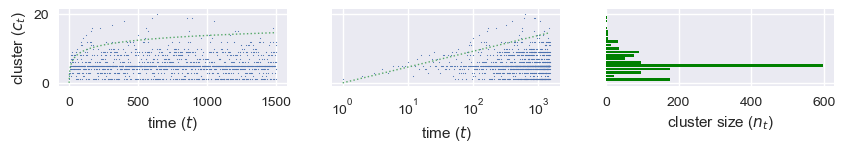

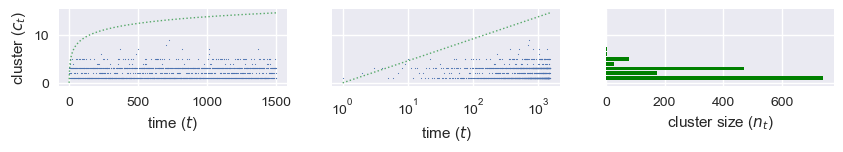

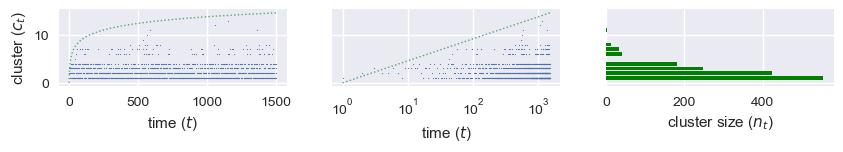

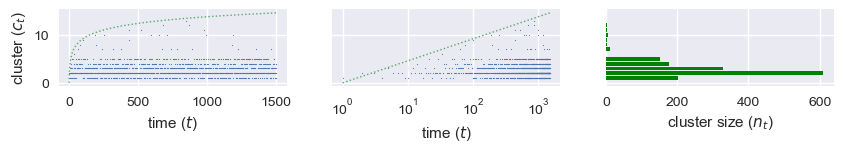

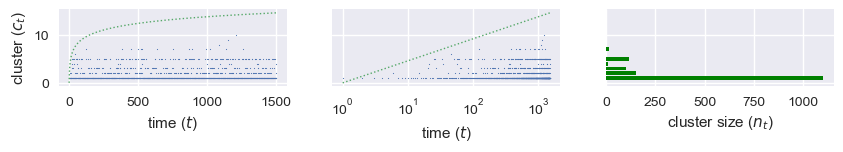

In [5]:
T = 1500
α = 2.0
num_examples = 5

(trs, ws, _) = importance_sampling(crp_model, (T, α), choicemap(), num_examples)
map(render_crp_trace, trs);

**More examples for varying $\alpha$**

The examples above are for a fixed concentration parameter $\alpha$. Next we plot some more historgrams over table assignments  but this time for varying values of $\alpha$. The values increase from top to bottom. 

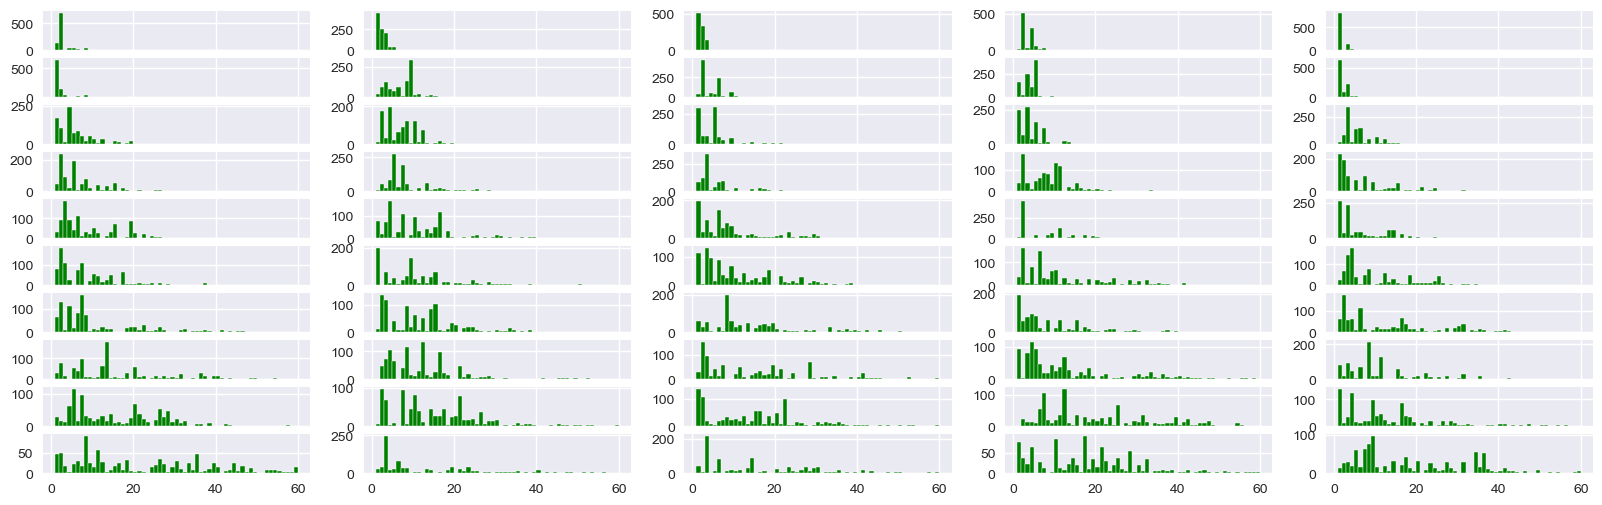

In [6]:
T = 1000

alphas  = 1.:2:20.
per_row = 5

fig, axs = plt.subplots(length(alphas), per_row, figsize=(20,6), sharex=true);    

for (i,α) in enumerate(alphas), j=1:per_row
        tr = simulate(crp_model, (T, α))
        c  = get_retval(tr)        
    
        axs[i,j].hist(c, bins=1:60, color="green", edgecolor="w");
end

## CRP mixture model

We are now taking the CRP model and use it as a prior for cluster assignments in a mixture model. 
Given a base distribution $𝐺_0$ over cluster parameters and a family of data distributions
$𝐹(\phi)$ we can define a non-parametric mixture model by

$$
\begin{eqnarray}
\boldsymbol c = (c_1, \ldots, c_T) &\sim& \text{CRP}(T; \alpha) \\
\phi_1,\ldots,\phi_k &\sim& G_0  \ \ \text{, where $k$ is the number of unique $c_t$}\\
x_t &\sim& F(\phi_{c_t}) \ \ \text{, for $t=1,\ldots,T$.}
\end{eqnarray}
$$

The corresponding Gen function, `crp_mixture_model` below, implements this process.
We also provide a few utility functions to deal with choicemaps related to this model.


**Remark** (CRP as DP)

It can be shown that $\theta_t := \phi_{c_t}$ are distributed according to a sample from a *Dirichlet Process* $\text{DP}(\alpha, G_0)$.
(apparently this follows from de Finetti's theorem...)

$$
\begin{eqnarray}
G &\sim& \text{DP}(\alpha, G_0) \\
\theta_t &\sim& G 
\end{eqnarray}
$$


**Remark** (DP as $\beta$-stick-breaking)

One can characterize the DP as a *stick-breaking* process as follows (Griffiths-Engen-McCloskey, look up references):
$$ 
 \left.\begin{aligned}
 \pi_1, \pi_2, \dots &\sim \text{GEM}(\alpha) \\
\phi_1, \phi_2, \ldots &\sim G_0  
 \end{aligned}\right\rbrace \ \ \ 
\Rightarrow \ \ \ \sum_{j=1}^\infty \pi_j \ \delta(\phi_j)  =: G \sim \text{DP}(\alpha, G_0)
$$



In [7]:
"""
    (c, phi, x) = crp_mixture_model(T::Int, 
                                    α::Float64, 
                                    F::Union{Distribution,DynamicDSLFunction}, 
                                    G0::Union{Distribution,DynamicDSLFunction})

Defines a non-parametric mixture model.
Cluster assignments are chosen according to a CRP 
with concentration parameter `α`, cluster parameters
are chosen from a base distribution `G0`, and the data
are generated from a family of distributions `F`.

"""
@gen function crp_mixture_model(
        T::Int, 
        α::Float64, 
        F::Union{Distribution,DynamicDSLFunction}, 
        G0::Union{Distribution,DynamicDSLFunction})
    
    # Cluster assignments     
    c = @trace(crp_model(T, α), :c)

    # Cluster parameters
    phi = Dict()    
    for i in Set(c)
        phi_i  = @trace(G0(), :phi => (:phi, i))
        phi[i] = phi_i
    end
    
    # Data points for each cluster
    x = []
    for t=1:T
        x_t = @trace(F(phi[c[t]]), :x => (:x, t))
        push!(x, x_t)
    end
    
    return (c, phi, x)
end;

### Examples

In [8]:
"""
    G0()

Basedistribution over cluster parameters.
"""
@gen function G0()
    mean = @trace(normal(0.,2.), :mean)
    std  = @trace(inv_gamma(100., 99.),  :std) # Recall: E(inv_gamma) = b/(a-1)
    return [mean; std]
end;


"""
    F(phi)

Family of data distributions conditioned 
on cluster parameters. 
"""
@gen function F(phi)::Float64
    mean, std = phi
    x = @trace(normal(mean, std), :x)
    return x
end;

In [9]:
T = 2
α = 1.

tr, = Gen.generate(crp_mixture_model, (T, α, F, G0))
ch = get_choices(tr) 
# 
# Rem: It sucks that we can't append the choice made by F to (:x,t)
# 

│
├── :c
│   │
│   ├── (:c, 1) : 1
│   │
│   └── (:c, 2) : 1
│
├── :phi
│   │
│   └── (:phi, 1)
│       │
│       ├── :std : 0.9331721372364334
│       │
│       └── :mean : 3.4252514839304022
│
└── :x
    │
    ├── (:x, 1)
    │   │
    │   └── :x : 3.0419567516697503
    │
    └── (:x, 2)
        │
        └── :x : 4.645187187712448


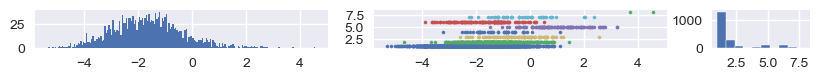

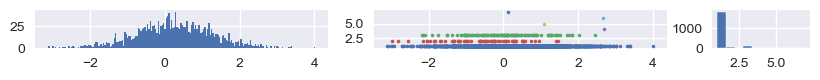

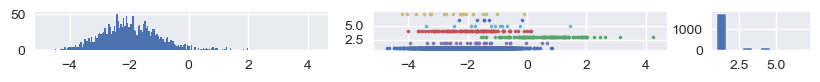

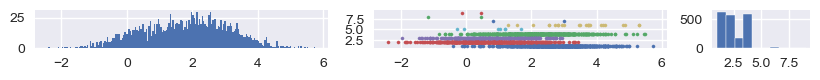

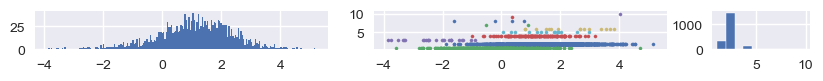

In [10]:
T = 2000
α = 1.
num_examples = 5

(trs, ws, _) = importance_sampling(crp_mixture_model, (T, α, F, G0), choicemap(), num_examples)
map(render_crp_mixture_tr, trs);

**Consistent cluster labels.**

Recall the sensitivity to the order of the $c_t$ in the remark above. Here is the promised function that relabels the tables accordingly, i.e. it changes the $c_t$'s and the $\phi_i$'s as if the were constructed by our model without changing the cluster memberships. Note in the example below that after relabeling we get a non-zero probability density.

In [11]:
"""
    relabel_tables(tr::Gen.Trace)

Relabels the tables according their allocation, i.e. 
it changes `c` and the `phi` as if the were 
constructed by the crp model without changing 
the cluster memberships. 
"""
function relabel_tables(tr::Gen.Trace)
    
    updates = choicemap() 
    labels  = Dict() # stores pairs `old_label => new_label`
    ch = get_choices(tr)
    T, = get_args(tr)
    k  = 1

    for t=1:T
        i = tr[:c => (:c, t)]
        
        if !haskey(labels, i)
            labels[i] = k
            set_submap!(updates, (:phi, k), get_submap(ch, (:phi,i)))
            k += 1                
        end
        
        updates[:c => (:c, t)] = labels[i]
    end

    tr,w, = Gen.update(tr, updates)
    return tr
end;

In [12]:
T = 2
α = .1
tr, = generate(crp_mixture_model, (T, α, F, G0), choicemap((:c => (:c,1)) => 2));
tr′ = relabel_tables(tr)
println("Original score:   ", get_score(tr))
println("After relabeling: ", get_score(tr′))

Original score:   -Inf
After relabeling: -4.963605895148643


In [13]:
@benchmark relabel_tables(tr)

BenchmarkTools.Trial: 
  memory estimate:  40.66 KiB
  allocs estimate:  563
  --------------
  minimum time:     43.348 μs (0.00% GC)
  median time:      48.994 μs (0.00% GC)
  mean time:        55.209 μs (8.50% GC)
  maximum time:     5.450 ms (98.90% GC)
  --------------
  samples:          10000
  evals/sample:     1

# Naive Inference

Now that we defined our CRP mixture model we can try to fit it to some data, i.e. we can try to infer the cluster asignments $c$ of a given set of data points $x$. Gen can generate a trace consistent with the observed data, and in principle we could try to generate traces untill we get a decent one. Below we illustrate that this naive approach does only work if the overall sampling space is small, which is rarely the case in pratice. 
For instance, the number of possible (CRP-)assignments $c$ for $t$ customers is

$$
    |\{ c : c = \text{crp}(t)| = \sum_{k=1}^t k^{t - k}.
$$

In [14]:
println("T=10  : |{c}| = ", sum([k^( 10 - k) for k=1: 10]))
println("T=100 : |{c}| = ", sum([BigInt(k)^(100 - k) for k=1:100]))

T=10  : |{c}| = 11378
T=100 : |{c}| = 4246248753004860968166954645369535173509829094289724873676081699924909305578368680226277209526026813750121


Obviously this is impossible to search through. 

Moreover there are two other variables, namely the cluster parameters, that have to be sampled. So the space becomes even larger. Below we illustrate this naive approach. As expected it only works for small $T$ &mdash; feel free to change the value of $T$ (and $\alpha$ as well) and convince yourself that this approach is doomed to fail for larger values of $T$.

We obviously need a more sophisticated inference procedure, which we will address in **PART 2**.

In [15]:
function create_toy_data(T)
    x = zeros(T)
    c = zeros(Int, T)
    for t=1:T
        b = bernoulli(0.5)
        x[t] = b ? F([-1.0;0.2]) : F([1.0;0.2])
        c[t] = b ? 1 : 2
    end
    return c,x
end;

function render_example(c,x)
    plt.figure(figsize=(3,0.5));
    for i in Set(c)
        plt.hist(x[c.==i], bins=-2:0.125:2, alpha=0.8);
    end
end;


"""
    set_obs!(upd, x)

Adds data constraints given by `x` to choicemap `upd`.
Depends on the trace structure of the data models. 
"""
function set_obs!(upd, x)
    for t=1:length(x)
       upd[:x => (:x, t) => :x] = x[t]
    end
end


"""
    get_obs(x)

Creates a choicemap with data constraints given by `x`.
Depends on the trace structure of the data models. 
"""
function get_obs(x)
    upd = choicemap()
    set_obs!(upd, x)
    return upd
end

get_obs

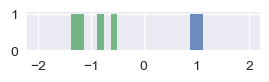

In [16]:
T   = 6
c,x = create_toy_data(T)
obs = get_obs(x);
render_example(c,x);

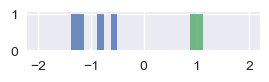

In [17]:
α = 1.
trs, ws, = Gen.importance_sampling(crp_mixture_model, (T, α, F, G0), obs, 10000);
c, phi, x = get_retval( trs[argmax(ws)]);
render_example(c,x);

<hr style="border:10px solid black"> </hr>

To be continued in `Part 2 - Inference only.ipynb` ...